In [16]:
%load_ext autoreload
%autoreload 2
import enum
import os
from weakref import ref
import pandas as pd 
import openpyxl
import numpy as np
import re
from collections import deque, defaultdict, OrderedDict
from unicodedata import normalize
import itertools
import math
import seaborn as sns
import torch
from data_interpolation import read_excel_file, build_out_file, group_df_data_by_car, get_training_inputs
from kde_model import KDENet,  train, build_df
import numpy as np
import japanize_matplotlib
import random
import torch 
from torch import nn
import torch.nn.functional as F
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib
# import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'IPAexGothic'
import japanize_matplotlib

In [11]:
cars, boxes, engines = [torch.randn(size=(1, k)) for k in [17, 25, 6]]
mu = torch.randn((1, 10))

In [14]:

class GaussianKernel(nn.Module):
    def __init__(self, dim, sigma):
        super().__init__()
        self.sigma = sigma
        self.dim = dim
        self.cov = torch.eye(dim).to(dtype=torch.float32) * self.sigma
        
    def forward(self, x, mu):
        x = x.unsqueeze(dim=1)
        prod = ( (x - mu) * (x-mu) ).sum(dim=2)
        prod = -0.5 * prod / self.sigma
        return torch.exp(prod)

class KDENet(nn.Module):
    
    def __init__(self, num_car=17, num_box=25, num_eng=6, ncluster=5, sigma=1.0, cluster_dim=10):
        super().__init__()
        self.net = nn.Linear(num_car + num_box + num_eng, 32)
        self.net1 = nn.Linear(32, cluster_dim)
        self.net2 = nn.Linear(32, ncluster)
        
        self.mu = nn.Linear(32, num_car + num_box + num_eng)
        
        self.kernel = GaussianKernel(num_car, sigma=sigma)
        self.leaky_rul = nn.LeakyReLU(0.2)
        self.sigma = sigma
        self.ncluster = ncluster
        self.cluster_dim = cluster_dim

    def forward(self, cars, boxes, engines, mu):
        x = torch.concat([cars, boxes, engines], dim=1)
        x = nn.ReLU()(self.net(x))
        feat = nn.ReLU()(self.net1(x))
        print(feat.shape, x.shape)
        
        y = nn.ReLU()(self.net2(x))
        print("Y shape: ", y.shape)
        x = self.leaky_rul(self.kernel(feat, mu))
        print("Kernel: ", x.shape, x)
        # out = x * y
        # out = nn.ReLU()(out.sum(dim=1))
        # return out, feat
net = KDENet()
net(cars, boxes, engines, mu)

torch.Size([1, 10]) torch.Size([1, 32])
Y shape:  torch.Size([1, 5])
Kernel:  torch.Size([1, 1]) tensor([[0.0084]], grad_fn=<LeakyReluBackward0>)


In [15]:
for folder in os.listdir("/home/barry/projects/nexco/toyota/data/MASTER_03/simulation_multi/"):
    print(folder)

model_10-1.0-32
model_15-1.0-32
model_5-2.0-10
model_5-1.0-10
model_10-1.0-20
model_5-0.5-10
model_30-1.0-64


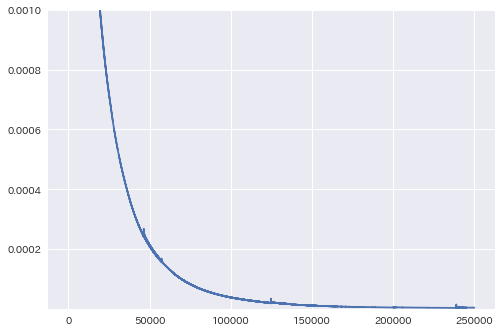

In [26]:
def plot_loss(filename):
    m = torch.load(filename)["losses"]
    fig, ax = plt.subplots()
    ax.plot(m)
    ax.set_ylim(0.0000004, 0.001)    


plot_loss("/home/barry/projects/nexco/toyota/data/MASTER_03/simulation_multi/model_5-0.5-10/CO2排出 - 最終的に求めたいバックデータ形式(燃費_中央値(中央)).pkl")